# `interp-acf` demo

Generate time series fluxes with two oscillation periods, and missing data:

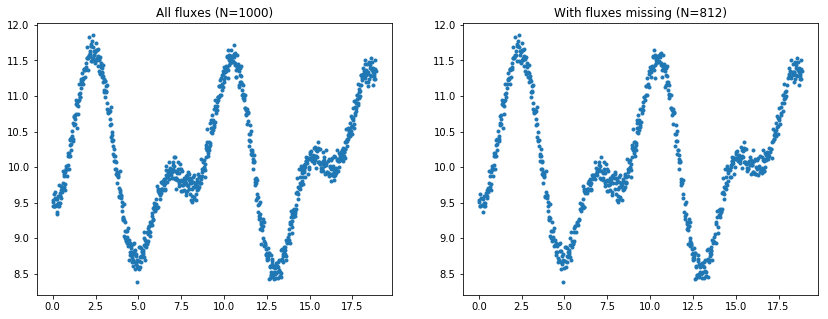

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Make flux time-series with random noise, and 
# two periodic oscillations, one 70% the amplitude
# of the other:
np.random.seed(42)
n_points = 1000
primary_period = 2.5*np.pi
secondary_period = 1.3*np.pi
all_times = np.linspace(0, 6*np.pi, n_points)
all_fluxes = 10 + (0.1*np.random.randn(len(all_times)) + 
                   np.sin(2*np.pi/primary_period * all_times) + 
                   0.7*np.cos(2*np.pi/secondary_period * (all_times - 2.5)))

# Remove some fluxes, times from those data: 
n_points_missing = 200  # This number is approximate
missing_indices = np.unique(np.random.randint(0, n_points, 
                                              size=n_points_missing))
mask = list(set(np.arange(len(all_times))).difference(set(missing_indices)))
times_incomplete = all_times[mask]
fluxes_incomplete = all_fluxes[mask]

# Plot these fluxes before and after data are removed:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(all_times, all_fluxes, '.')
ax[0].set(title='All fluxes (N={0})'.format(len(all_fluxes)))
ax[1].plot(times_incomplete, fluxes_incomplete, '.')
ax[1].set(title='With fluxes missing (N={0})'.format(len(fluxes_incomplete)))
plt.show()

Now we'll use two `interpacf` methods on these simulated fluxes: 

* `interpacf.interpolated_acf` will interpolate over the missing fluxes and compute the autocorrelation function. Don't forget to subtract the flux its mean!

* `interpacf.dominant_period` returns the lag with the highest peak in the smoothed autocorrelation function. The default smoothing kernel matches that of [McQuillan, Aigrain & Mazeh (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.432.1203M)



Actual dominant period: 7.854
Detected dominant period: 7.962
Difference: -0.014%


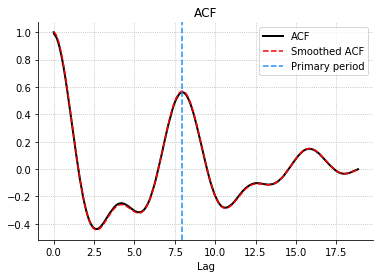

In [2]:
from interpacf import interpolated_acf, dominant_period

# Need zero-mean fluxes: 
fluxes_incomplete -= np.mean(fluxes_incomplete)

# Compute autocorrelation function
lag, acf = interpolated_acf(times_incomplete, fluxes_incomplete)

# Find dominant period in autocorrelation function
detected_period = dominant_period(lag, acf, plot=True)

print("Actual dominant period: {0:.3f}\nDetected dominant period: "
      "{1:.3f}\nDifference: {2:.3f}%"
      .format(primary_period, detected_period, 
              (primary_period - detected_period)/primary_period))

# Comparing with McQuillan, Aigrain & Mazeh (2013)

...for my favorite star, HAT-P-11. McQuillan et al. find a rotation period of 29.472 d. What do we find? 

This example makes use of the `kplr` package to download Kepler data. You'll need to install it to run this example, which you can do with: 
```
pip install kplr
```
First download and normalize each quarter of the HAT-P-11 Kepler light curve:

In [3]:
import numpy as np
import kplr
client = kplr.API()

# Find the target KOI.
koi = client.koi(3.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for lc in lcs[1:]:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
        time.append(hdu_data["time"])
        flux.append(hdu_data["sap_flux"])
        ferr.append(hdu_data["sap_flux_err"])
        quality.append(hdu_data["sap_quality"])

time = np.array(time)
# Median normalize each quarter of observations
flux = np.array([f/np.nanmedian(f) - 1 for f in flux])

Now measure the peak in the autocorrelation function for each quarter's light curve: 

In [13]:
%matplotlib inline
periods = []
for i, t, f in zip(range(len(time)), time, flux):
    
    lag, acf = interpolated_acf(t[~np.isnan(f)], f[~np.isnan(f)])
    period = dominant_period(lag, acf)
    periods.append(period)
    print("HAT-P-11 period in Q{0}: {1} d".format(i, period))

HAT-P-11 period in Q0: 27.87245554981928 d
HAT-P-11 period in Q1: 30.242006851767655 d
HAT-P-11 period in Q2: 29.97501441694476 d
HAT-P-11 period in Q3: 29.91453296065447 d
HAT-P-11 period in Q4: 28.424119883165986 d
HAT-P-11 period in Q5: 58.62456519744592 d
HAT-P-11 period in Q6: 29.260692983400077 d
HAT-P-11 period in Q7: 30.590147634444293 d
HAT-P-11 period in Q8: 29.220380285405554 d
HAT-P-11 period in Q9: 30.507091305764334 d
HAT-P-11 period in Q10: 51.67836866840298 d
HAT-P-11 period in Q11: 28.546062678855378 d
HAT-P-11 period in Q12: 29.281246874539647 d
HAT-P-11 period in Q13: 27.606573058765207 d


Compare with McQuillan+ 2013: 

In [14]:
print("Median period (interpacf): {0};\n"
      "Period McQuillan+ 2013: 29.472"
      .format(np.median(periods))

Median period (interpacf): 29.59788991759706;
Period McQuillan+ 2013: 29.472
